In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, poisson, gamma, beta, uniform
import sys

def constrain_likelihoods(
    likelihoods_mat, ## 2-D np array, shape (*, n_prop); flexible length, equal to n_models total from safe model to curr
    betas, ## 1-D np array of lik-ratio bounds
    psis ## 1-D np array of normalization constants
):
    n_models, n_prop = np.shape(likelihoods_mat)

    constrained_likelihoods_mat = np.zeros((n_models, n_prop))

    ## First row of likelihoods_mat should already be safe/constrained
    constrained_likelihoods_mat[0] = likelihoods_mat[0] 

    ## Compute constrained likelihoods for each subsequent policy and bound
    for i in range(1, n_models):
        constrained_likelihoods_mat[i] = np.where(likelihoods_mat[i] / constrained_likelihoods_mat[i-1] < betas[i], \
                                                  likelihoods_mat[i] / psis[i], betas[i] * constrained_likelihoods_mat[i-1] / psis[i])
    
    return constrained_likelihoods_mat

def iwmci_prop_est(
    LRs_unconstrained_over_safe, ## 1D numpy array
    unconstrained_liks,
    safe_liks,
    beta_t, ## float
    psi_t,
    proposal: str = "safe"
):
    # iwmci_est = importance_weighted_monte_carlo_integration(LRs_unconstrained_over_safe, beta_t, "safe")
    # return np.mean(LRs_unconstrained_over_safe[LRs_unconstrained_over_safe < beta_t]) / iwmci_est
    if proposal == "unconstrained":
        ## If beta_t >= 1: Assume proposal is unconstrained
        return np.mean(np.minimum(np.minimum(beta_t * safe_liks, unconstrained_liks)/psi_t, unconstrained_liks)/unconstrained_liks)


    elif proposal == "safe":
        ## Else, beta_t < 1: Assume proposal is safe
        # return np.mean(np.minimum(LRs_unconstrained_over_safe, beta_t))
        return np.mean(np.minimum(np.minimum(beta_t * safe_liks, unconstrained_liks)/psi_t, safe_liks)/safe_liks)

    else:
        raise ValueError(f"Unrecognized proposal name : {proposal}")


/tmp/ipykernel_1768493/1466605214.py:84: RuntimeWarning: overflow encountered in scalar divide
  scaled_ratio = lik_ratio / beta


Beta : 2.2250738585072014e-308
True Norm Const : 2.2190675299381217e-308
Norm Const Est : 2.2250738585072014e-308
Overlap Coefficient Est (1-TV dist est) : 0.9999999999999997
num_proposals : 5000
n_target : 5000


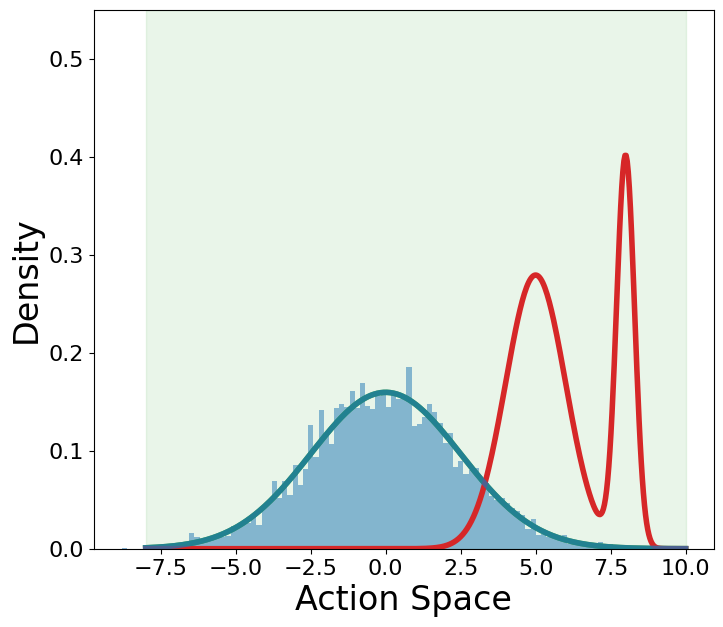

Beta : 1e-10
True Norm Const : 7.929194920865032e-11
Norm Const Est : 7.932159151169501e-11
Overlap Coefficient Est (1-TV dist est) : 0.7968256711422438
num_proposals : 6307
n_target : 5000


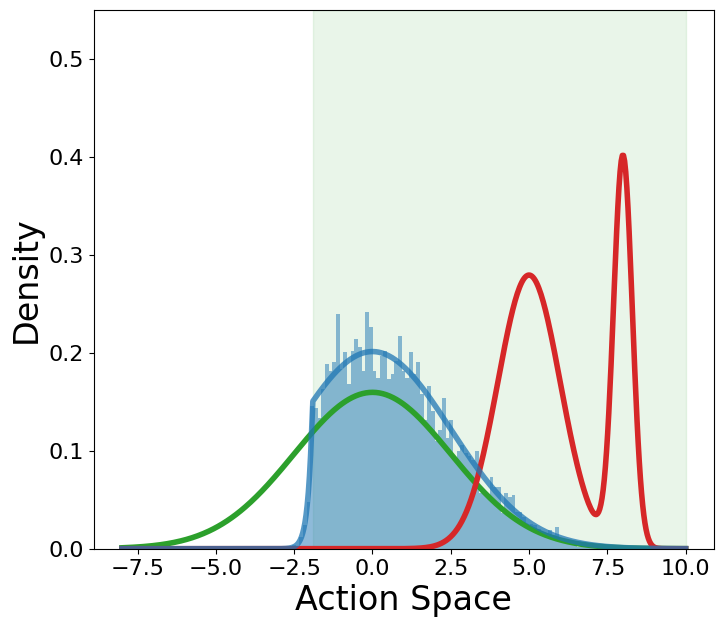

Beta : 1
True Norm Const : 0.12425562935331762
Norm Const Est : 0.12510192272053153
Overlap Coefficient Est (1-TV dist est) : 0.5032544780735837
num_proposals : 40362
n_target : 5000


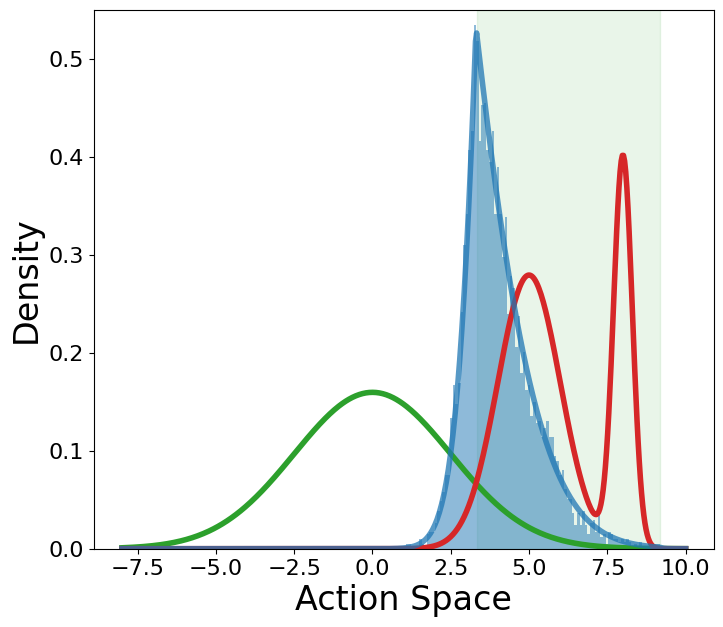

Beta : 100
True Norm Const : 0.8182723745581548
Norm Const Est : 0.8190108305061619
Overlap Coefficient Est (1-TV dist est) : 0.8386193954558624
num_proposals : 6071
n_target : 5000


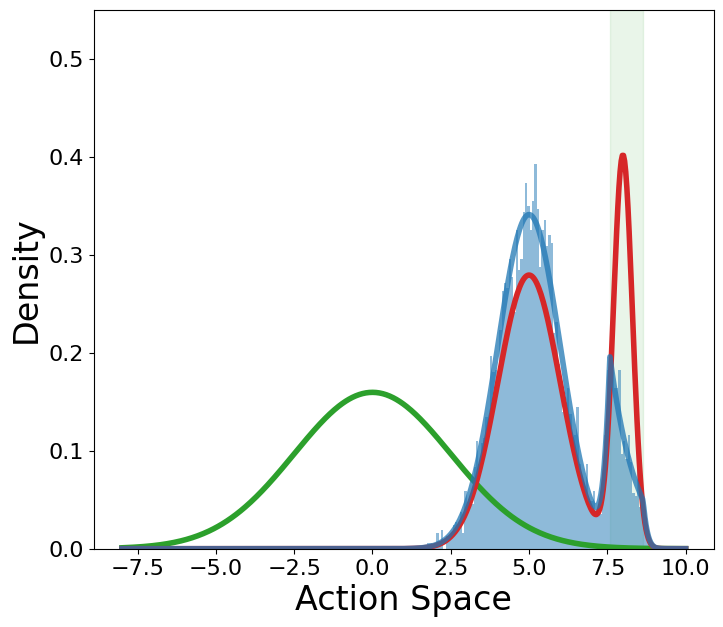

Beta : inf
True Norm Const : 1.0
Norm Const Est : 1.0
Overlap Coefficient Est (1-TV dist est) : 1.0
num_proposals : 5000
n_target : 5000


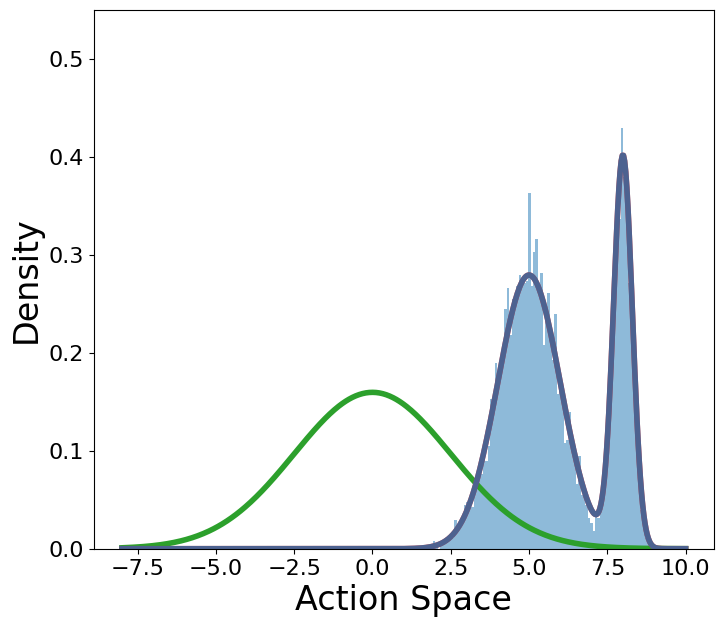

In [8]:


x_values = np.linspace(-8, 10, 500) # For plotting the curve


## Safe policy
m0 = 0
s0 = 2.5
pdf0_values = norm.pdf(x_values, loc=m0, scale=s0)
def pdf0(x):
    return norm.pdf(x, loc=m0, scale=s0)


## Optimized policy
m1 = 5
s1 = 1
# pdf1_values = norm.pdf(x_values, loc=m1, scale=s1)
# def pdf1(x):
#     return norm.pdf(x, loc=m1, scale=s1)
pdf1_values = 0.7 * norm.pdf(x_values, loc=m1, scale=s1) + 0.3 * norm.pdf(x_values, loc=m1+3, scale=0.3*s1)
def pdf1(x):
    return 0.7 * norm.pdf(x, loc=m1, scale=s1) + 0.3 * norm.pdf(x, loc=m1+3, scale=0.3*s1)


## Lik ratios
lik_ratios = pdf1_values / pdf0_values

## Betas to search over
betas = [sys.float_info.min, 10**(-10), 1, 100, np.inf]

## Num target samples
n_target = 5000



for i, beta in enumerate(betas):

    
    pdf1_constrained_values = np.where(lik_ratios < beta, pdf1_values, beta*pdf0_values) ## Constrained PDF (unnormalized)
    x_constraint_solution_ = np.where(lik_ratios < beta, True, False) ## For determining piecewise condition
    
    if np.sum(x_constraint_solution_) == len(x_constraint_solution_):
        ## If True everywhere:
        idx_x_left = -1
        idx_x_right = -1
        
    else:
        idx_x_left = np.argmin(x_constraint_solution_)
        idx_x_right = x_constraint_solution_.size - np.argmin(x_constraint_solution_[::-1]) - 1 

    
    x_constraint_solution = x_values[np.sum(x_constraint_solution_)-1]
    if i == len(betas)-1:
        ## Unconstrained case
        x_constraint_solution = -4


    # if (beta_quantiles[i] <= 0.7):
    # norm_const_est
    # weight_else = 0
    norm_const_est_vals = []
    safe_norm_const_est_vals = []
    lr_ratio_vals = []
    unconstrained_liks = []
    safe_liks = []
    num_proposals = 0


    
    ## Rejection sampling from safe dist
    if (beta < 1.0):
        accepted_samples = []

        ## Continue sampling with safe policy proposal until reach target number
        while (len(accepted_samples) < n_target):

            ## Draw safe proposal and uniform
            num_proposals += 1
            u = uniform.rvs()
            safe_sample = norm.rvs(loc=m0, scale=s0)

            ## Recording likelihoods, lik-ratio, and scaled lik-ratio
            unconstrained_liks.append(pdf1(safe_sample))
            safe_liks.append(pdf0(safe_sample))
            lik_ratio = unconstrained_liks[-1]/safe_liks[-1]
            scaled_ratio = lik_ratio / beta
            lr_ratio_vals.append(lik_ratio)

            ## Record IWMCI info
            norm_const_est_vals.append(min(lik_ratio, beta)) ## For IWMCI normalization constant estimation

            ## Determine whether to accept sample
            if (u < scaled_ratio):
                accepted_samples.append(safe_sample)


    ## Rejection sampling with optimized policy proposal
    else:
        accepted_samples = []
        
        ## Continue sampling with optimized policy proposal until reach target number
        while (len(accepted_samples) < n_target):
            num_proposals += 1
            u = uniform.rvs()

            ## Sampling from optimized policy (it's a mixture)
            u2 = uniform.rvs()
            if u2 <= 0.7:
                unconstrained_sample = norm.rvs(loc=m1, scale=s1)
            else:
                unconstrained_sample = norm.rvs(loc=m1+3, scale=0.3*s1)

            ## Recording likelihoods, lik-ratio, and scaled lik-ratio
            unconstrained_liks.append(pdf1(unconstrained_sample))
            safe_liks.append(pdf0(unconstrained_sample))
            lik_ratio = unconstrained_liks[-1]/safe_liks[-1]
            scaled_ratio = beta/lik_ratio ## Note it's reciprocal of safe proposal case
            lr_ratio_vals.append(lik_ratio)


            ## Record IWMCI info
            norm_const_est_vals.append(min(scaled_ratio, 1))
            safe_norm_const_est_vals.append(min(lik_ratio, beta))


            ## Determine whether to accept sample
            if (u < scaled_ratio):
                accepted_samples.append(unconstrained_sample)

    

    ## Array of LRs and likelihoods
    lr_ratio_vals_arr = np.array(lr_ratio_vals)
    unconstrained_liks_arr = np.array(unconstrained_liks)
    safe_liks_arr = np.array(safe_liks)

    
    # IWMCI to estimate constrained policy normalization constant
    norm_const_est = np.mean(norm_const_est_vals)


    ## Estimating the "Overlap Coefficient" (i.e., 1-TV distance) between proposal and constrained policy
    if beta < 1.0:
        # safe_norm_const_est = iwmci_safe_est(lr_ratio_vals_arr, beta, "safe")
        intersect_norm_const_est = iwmci_prop_est(
            lr_ratio_vals_arr, ## 1D numpy array
            unconstrained_liks_arr,
            safe_liks_arr,
            beta, ## float
            norm_const_est,
            proposal = "safe"
        )
    else:
        # safe_norm_const_est = iwmci_safe_est(lr_ratio_vals_arr, beta, "unconstrained")
        intersect_norm_const_est = iwmci_prop_est(
            lr_ratio_vals_arr, ## 1D numpy array
            unconstrained_liks_arr,
            safe_liks_arr,
            beta, ## float
            norm_const_est,
            proposal = "unconstrained"
        )
        

    
    norm_const = (np.sum(pdf1_constrained_values) * (np.max(x_values) - np.min(x_values)) / len(x_values)) if beta < np.inf else 1.0
    
    print(f'Beta : {beta}')

    print(f"True Norm Const : {norm_const}")
    print(f"Norm Const Est : {norm_const_est}")
    print(f"Overlap Coefficient Est (1-TV dist est) : {intersect_norm_const_est}")

    print(f"num_proposals : {num_proposals}")
    print(f"n_target : {n_target}")

    liks_mat = np.vstack((pdf0_values, pdf1_values))
    betas_curr = np.array([None, beta])
    psis_curr = np.array([None, norm_const_est])
    constrained_liks = constrain_likelihoods(liks_mat, betas_curr, psis_curr)
    pdf1_constrained_values_normalized = constrained_liks[-1]


    plt.figure(figsize=(8, 7))

    if (beta < max(betas)):
        plt.axvspan(xmin=x_values[idx_x_left], xmax=x_values[idx_x_right], alpha = 0.1, color='C2')



    plt.plot(x_values, pdf0_values, label='Safe Policy', color='C2', linewidth=4)
    plt.plot(x_values, pdf1_values, label='Unconstrained Policy', color='C3', linewidth=4)
    plt.plot(x_values, pdf1_constrained_values_normalized, label='Constrained Policy', color='C0', alpha = 0.75, linewidth=4)
    plt.hist(np.array(accepted_samples), bins=100, density=True, alpha = 0.5, label='AR Samples')



    plt.xlabel('Action Space', fontsize=24)
    plt.ylabel('Density', fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim([0, 0.55])
    # plt.legend(loc=[0, 1.12], ncols=2, fontsize=14)
    plt.savefig(f'./constrained_ex_beta{betas[i]:2e}.pdf', dpi=200, bbox_inches='tight', pad_inches=0.0)
    plt.show()
    

